In [1]:
from google.colab import drive
drive._mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
from PIL import Image
import seaborn as sns

In [3]:
# data_path = "drive/MyDrive/Projects/CNS/ML Hiring Test Materials/Data/Image Classification Data/data" 
data_path = "drive/MyDrive/Projects/CNS/Resize2" 

# Model from scratch

In [12]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
print(tf.__version__)
# !pip install tensorflow.io
# import tensorflow_io as tfio

import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.layers.core import Activation
from tensorflow.keras.callbacks import EarlyStopping

2.7.0


In [4]:

def show_final_history(history):
  # plot accuracy plots of the models
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [75]:
labels = os.listdir(f'{data_path}/train')
num_classes = len(labels)
list_ds = tf.data.Dataset.list_files(str(f'{data_path}/train/*/*'),name = 'organ')
test_list_df = tf.data.Dataset.list_files(str(f'{data_path}/test/*/*'),name = 'organ_test')

def label_to_int(label):
  if 'colon' ==label:
    label_int = 10
  elif 'endometrium_1' ==label:
    label_int = 11
  elif 'endometrium_2' ==label:
    label_int = 8
  elif 'kidney' ==label:
    label_int = 5
  elif 'liver' ==label:
    label_int = 6
  elif 'lung' ==label:
    label_int = 2
  elif 'lymph_node' ==label:
    label_int = 7
  elif 'pancreas' ==label:
    label_int = 9
  elif 'skin_1' ==label:
    label_int = 3
  elif 'skin_2' ==label:
    label_int = 0
  elif 'small_intestine' ==label:
    label_int = 1
  elif 'spleen' ==label:
    label_int = 4
  else:
    label_int = -1 
  return label_int

def process_path(file_path):
  label_str = tf.strings.split(file_path, os.sep)[-2]
  label = label_to_int(label_str)
  image = tf.io.read_file(file_path)
  # image = tfio.experimental.image.decode_tiff(image)
  image = tf.io.decode_png(image)
  # image = tf.image.resize(image, [200,200])
  return image, label


labeled_ds = list_ds.map(process_path)
test_ds = test_list_df.map(process_path)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

labeled_ds = labeled_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = labeled_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_ds = labeled_ds
DATASET_SIZE = len(normalized_ds)
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)
test_dataset = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

train_dataset = normalized_ds.take(train_size)
val_dataset = normalized_ds.skip(train_size)
train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)


In [10]:
img_height = 224
img_width = 224

In [149]:


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(height_factor=(0.1,0.3))
])
es = EarlyStopping(monitor='val_loss', mode='min')
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
  data_augmentation,
  layers.Conv2D(8, 5, padding='same', activation='relu',use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(16, 5, padding='same', activation='relu',use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(32, 5, padding='same', activation='relu',use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, 5, padding='same', activation='relu',use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2), 
  # layers.Conv2D(64, 5, padding='same', activation='relu'),
  # layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(64,use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 8)       608       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)     

In [150]:
# labeled_ds = labeled_ds.cache().shuffle(1000).prefetch(buffer_size=32)
history = model.fit(train_dataset, epochs=20,verbose=True,validation_data=val_dataset)

Epoch 1/20
60/60 [==============================] - 11s 68ms/step - loss: 3.9763 - accuracy: 0.2823 - val_loss: 4.0338 - val_accuracy: 0.0875
Epoch 2/20
60/60 [==============================] - 4s 60ms/step - loss: 3.0346 - accuracy: 0.3844 - val_loss: 3.4564 - val_accuracy: 0.1500
Epoch 3/20
60/60 [==============================] - 3s 55ms/step - loss: 2.6023 - accuracy: 0.3896 - val_loss: 3.2285 - val_accuracy: 0.1833
Epoch 4/20
60/60 [==============================] - 3s 57ms/step - loss: 2.3415 - accuracy: 0.4229 - val_loss: 4.0729 - val_accuracy: 0.1375
Epoch 5/20
60/60 [==============================] - 4s 61ms/step - loss: 2.2657 - accuracy: 0.4323 - val_loss: 3.6759 - val_accuracy: 0.1667
Epoch 6/20
60/60 [==============================] - 3s 49ms/step - loss: 2.1139 - accuracy: 0.4375 - val_loss: 2.7531 - val_accuracy: 0.2042
Epoch 7/20
60/60 [==============================] - 3s 49ms/step - loss: 2.0826 - accuracy: 0.4510 - val_loss: 2.6092 - val_accuracy: 0.2417
Epoch 8/20
6

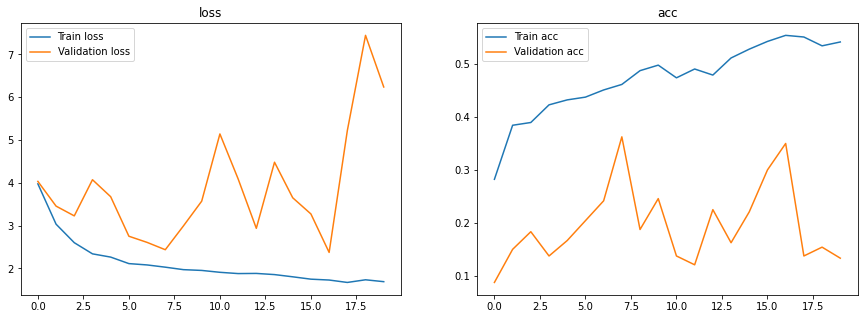

In [151]:
show_final_history(history)

In [ ]:
model.evaluate(test_dataset)

38/38 [==============================] - 53s 1s/step - loss: 2.9202 - accuracy: 0.1183


[2.9201817512512207, 0.11833333224058151]

In [ ]:
# import tensorflow_datasets as tfds

Pretrained Models

In [16]:
from tensorflow.python.keras import activations

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(height_factor=(0.1,0.3))
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_classes,activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
pretrained_model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step
(16, 7, 7, 1280)
(16, 1280)
(16, 12)


In [18]:
# es = EarlyStopping(monitor='val_accuracy', mode='min')
history = pretrained_model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset)
                    # callbacks = [es])

Epoch 1/20
60/60 [==============================] - 9s 80ms/step - loss: 1.9646 - accuracy: 0.3604 - val_loss: 1.4545 - val_accuracy: 0.4667
Epoch 2/20
60/60 [==============================] - 4s 61ms/step - loss: 1.1278 - accuracy: 0.5906 - val_loss: 1.1877 - val_accuracy: 0.5750
Epoch 3/20
60/60 [==============================] - 4s 63ms/step - loss: 0.8971 - accuracy: 0.6958 - val_loss: 1.0411 - val_accuracy: 0.6167
Epoch 4/20
60/60 [==============================] - 4s 61ms/step - loss: 0.7862 - accuracy: 0.7167 - val_loss: 0.9272 - val_accuracy: 0.6875
Epoch 5/20
60/60 [==============================] - 4s 62ms/step - loss: 0.7117 - accuracy: 0.7625 - val_loss: 0.9482 - val_accuracy: 0.6917
Epoch 6/20
60/60 [==============================] - 4s 61ms/step - loss: 0.6597 - accuracy: 0.7802 - val_loss: 0.8642 - val_accuracy: 0.7167
Epoch 7/20
60/60 [==============================] - 4s 65ms/step - loss: 0.6265 - accuracy: 0.7781 - val_loss: 0.8435 - val_accuracy: 0.7167
Epoch 8/20
60

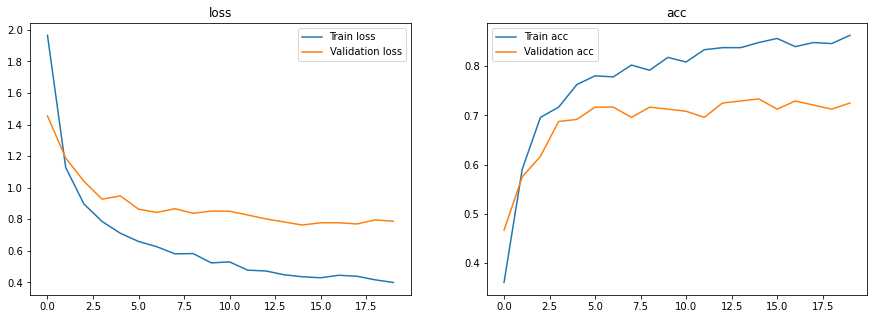

In [21]:
show_final_history(history)

In [19]:
loss0, accuracy0 = pretrained_model.evaluate(test_dataset)

38/38 [==============================] - 53s 1s/step - loss: 0.8549 - accuracy: 0.7067


In [ ]:
# lr = 0.001, epochs = 20 tra = 89% val = 80% test = 74%

In [ ]:
pretrained_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_14 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

Visualization

In [20]:
labels

['skin_2',
 'small_intestine',
 'lung',
 'skin_1',
 'spleen',
 'kidney',
 'liver',
 'lymph_node',
 'endometrium_2',
 'pancreas',
 'colon',
 'endometrium_1']

<Figure size 432x288 with 0 Axes>

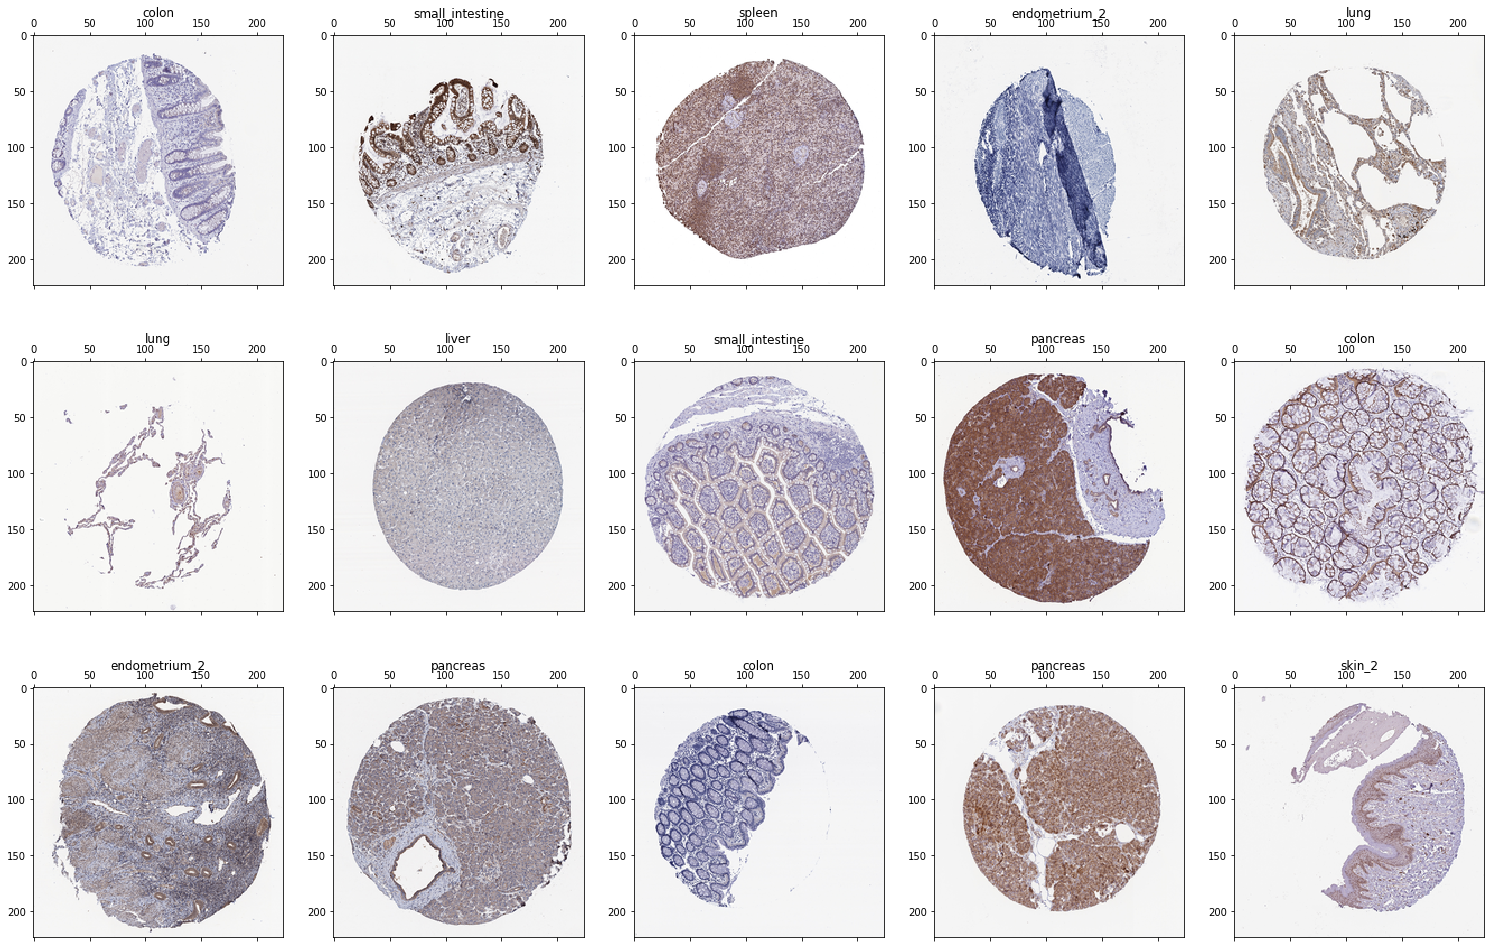

In [28]:
plt.gray()
fig = plt.figure( figsize=(26,17) )
for i in range(0,15):
    label = np.random.choice(labels)
    file_name = np.random.choice(os.listdir(f'{data_path}/train/{label}'))
    ax = fig.add_subplot(3,5,i+1, title=label )
    image = Image.open(f'{data_path}/train/{label}/{file_name}')
    imarray = np.array(image)
    ax.matshow(imarray)
plt.show()

<Figure size 432x288 with 0 Axes>

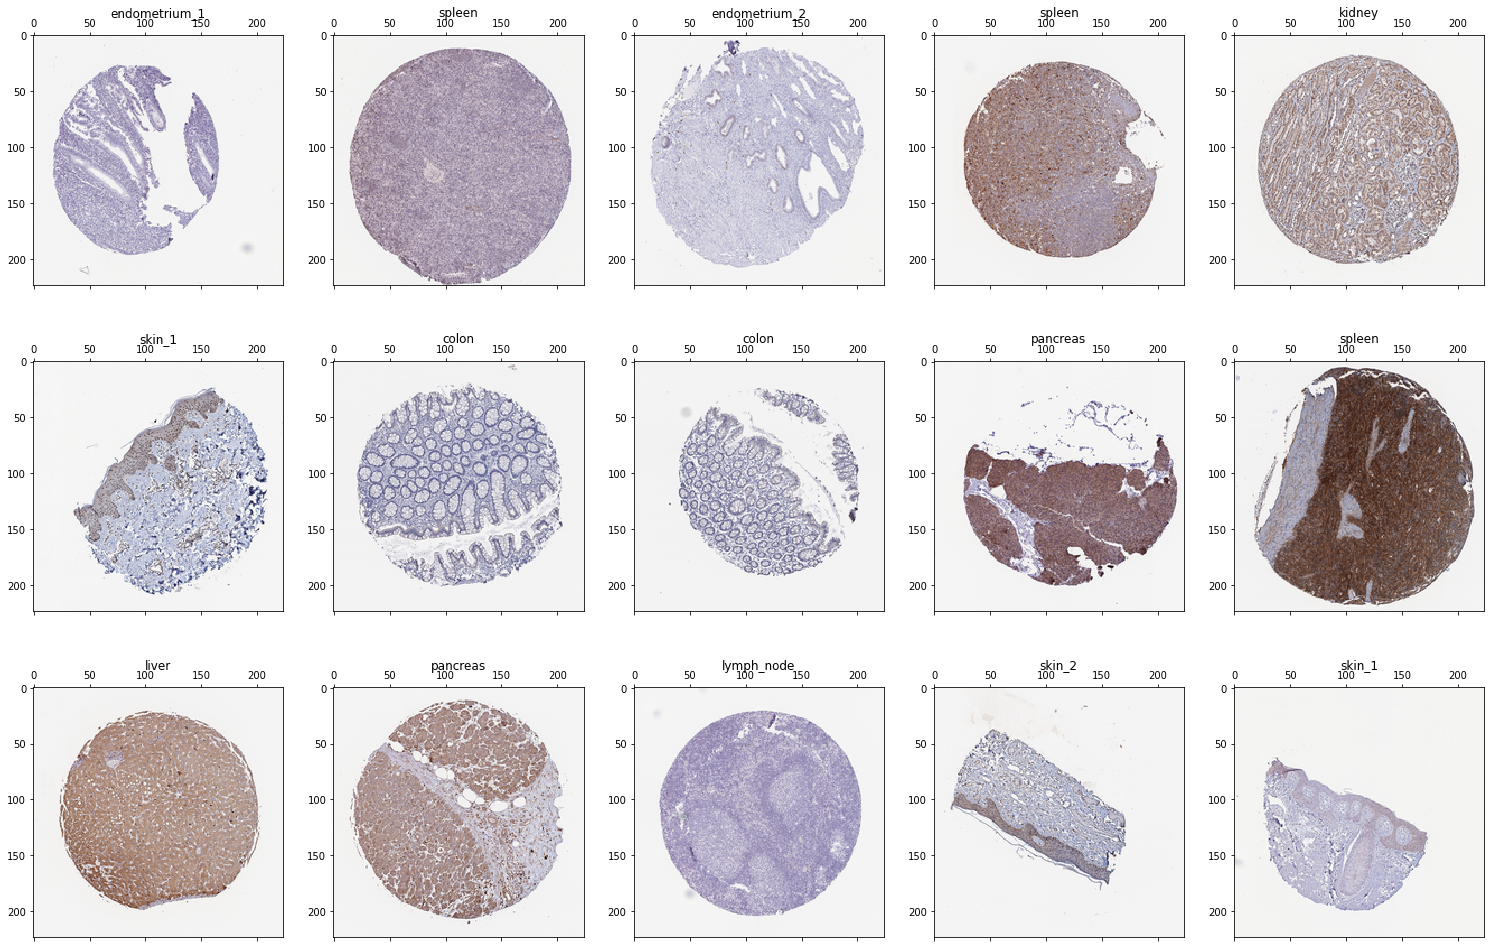

In [29]:
plt.gray()
fig = plt.figure( figsize=(26,17) )
for i in range(0,15):
    label = np.random.choice(labels)
    file_name = np.random.choice(os.listdir(f'{data_path}/test/{label}'))
    ax = fig.add_subplot(3,5,i+1, title=label )
    image = Image.open(f'{data_path}/test/{label}/{file_name}')
    imarray = np.array(image)
    ax.matshow(imarray)
plt.show()

In [160]:
final_df = pd.DataFrame()
label_list = []
for label in labels:
  dir_list = os.listdir(f'{data_path}/train/{label}')
  for im_file in dir_list:
    image = Image.open(f'{data_path}/train/{label}/{im_file}')
    one_image = imarray.flatten()
    final_df = final_df.append(pd.DataFrame(one_image).T)
    # train_arrays.append(one_image)
    label_list.append(label)

In [161]:
final_df.shape

(1200, 150528)

In [162]:
tsne_train = TSNE(n_components=2,init = 'random')
train_X_embed = tsne_train.fit_transform(final_df)
final_df['tsne 1'] = train_X_embed[:,0]
final_df['tsne 2'] = train_X_embed[:,1]
final_df['labels'] = label_list


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Train TSNE')

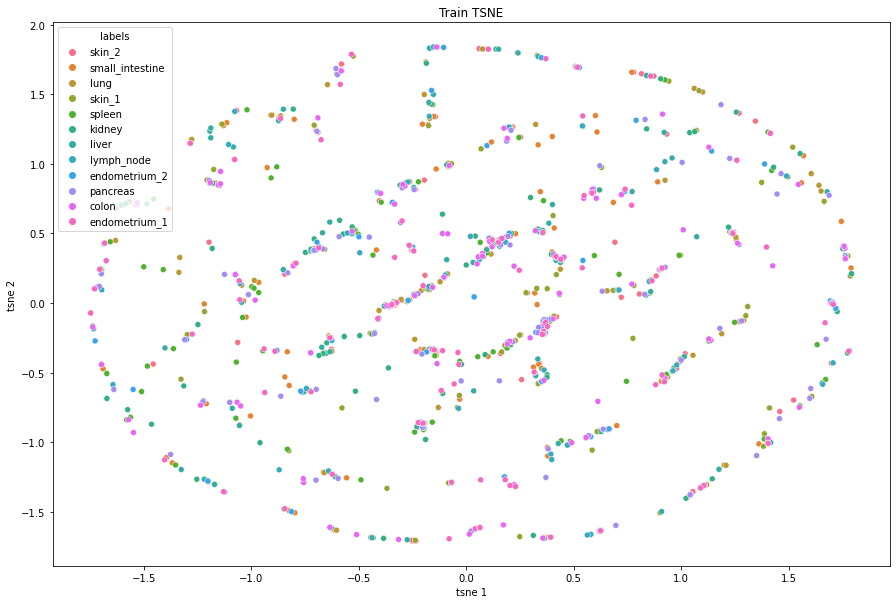

In [163]:

# plt.plot(train_X_embed)
plt.figure(figsize = (15,10))
sns.scatterplot(x = 'tsne 1', y = 'tsne 2',hue = 'labels',data = final_df)
plt.title("Train TSNE")

In [164]:
final_test_df = pd.DataFrame()
label_test_list = []
for label in labels:
  dir_list = os.listdir(f'{data_path}/test/{label}')
  for im_file in dir_list:
    image = Image.open(f'{data_path}/test/{label}/{im_file}')
    one_image = imarray.flatten()
    final_test_df = final_test_df.append(pd.DataFrame(one_image).T)
    # train_arrays.append(one_image)
    label_test_list.append(label)

In [165]:
final_test_df.shape

(600, 150528)

In [166]:
tsne_test = TSNE(n_components=2,init = 'random')
test_X_embed = tsne_test.fit_transform(final_test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Test TSNE')

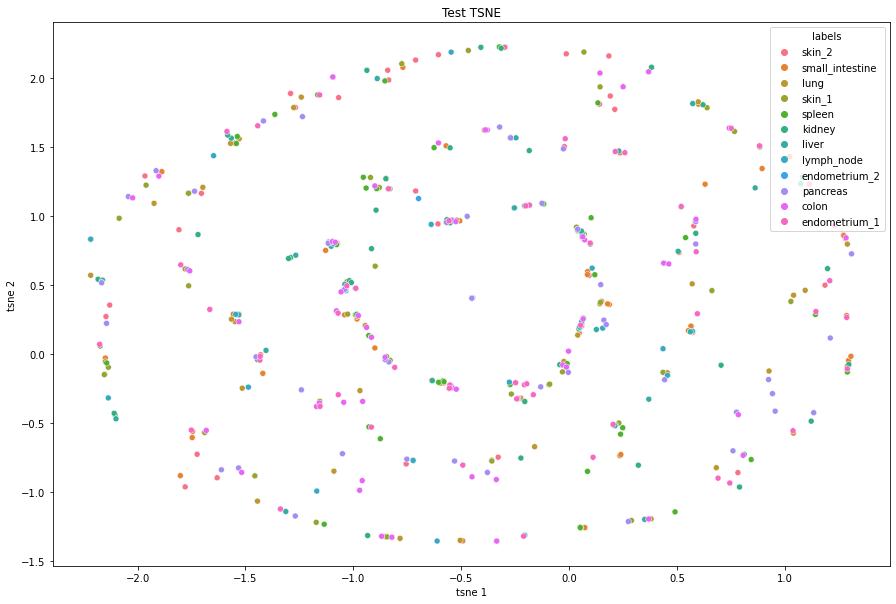

In [167]:
final_test_df['tsne 1'] = test_X_embed[:,0]
final_test_df['tsne 2'] = test_X_embed[:,1]
final_test_df['labels'] = label_test_list

plt.figure(figsize = (15,10))
sns.scatterplot(x = 'tsne 1', y = 'tsne 2',hue = 'labels',data = final_test_df)
plt.title("Test TSNE")

In [125]:
predicts = np.argmax(pretrained_model.predict(test_dataset),axis= 1)

In [131]:
test_check_df = test_dataset.unbatch()
test_arrays = []
test_true_labels = []
for t_images,true_l in test_check_df:
  test_arrays.append(t_images.numpy())
  test_true_labels.append(true_l.numpy())


In [129]:
test_false_index = [i for i in range(len(predicts)) if predicts[i]!= test_true_labels[i]]

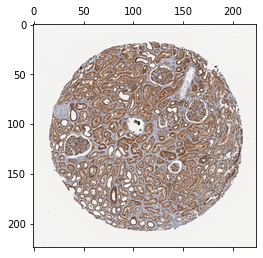

In [136]:
index = np.random.choice(test_false_index)
plt.matshow(test_arrays[index])


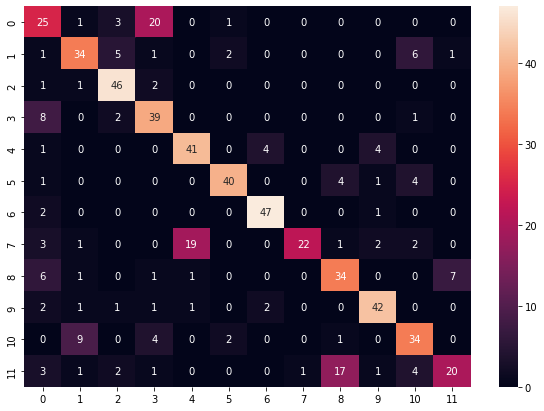

In [145]:
plt.figure(figsize = (10,7))
sns.heatmap(tf.math.confusion_matrix(test_true_labels,predicts).numpy(), annot = True)

In [148]:
for i in range(len(labels)):
  print(i,labels[i])
# labels

0 skin_2
1 small_intestine
2 lung
3 skin_1
4 spleen
5 kidney
6 liver
7 lymph_node
8 endometrium_2
9 pancreas
10 colon
11 endometrium_1


Major misclassifications: 
1. skin_2 and skin_1
2. lymph_node and spleen
3. endometrium_1 and endometrium_2